## Datasets:
* **SQuAD (Stanford Question Answering Dataset):** ***Chosen***
1. Contains 107,785 question-answer pairs on 536 articles.
2. In SQuAD, the correct answers of questions can be any sequence of tokens in the given text.
3. Because the questions and answers are produced by humans through crowdsourcing, it is more diverse than some other question-answering datasets.


* **Natural Questions:**
1. Contains 307,373 training examples, 7,830 development examples, and 7,842 test examples.
2. The long and the short answer annotations can however be empty. If they are both empty, then there is no answer on the page at all.
3. Finally 1% of the documents have a passage annotated with a short answer that is “yes” or “no”, instead of a list of short spans.


* **TriviaQA:**
1. Contains 950K question-answer pairs from 662K documents collected from Wikipedia and the web.
2. This dataset is more challenging as the answers for a question may not be directly obtained by span prediction and the context is very long. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
import random
import string

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors
from gensim.downloader import load

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Model


2025-04-22 19:50:04.613584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745351404.637083     346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745351404.644632     346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
splits = {
    'train': 'plain_text/train-00000-of-00001.parquet',
    'validation': 'plain_text/validation-00000-of-00001.parquet'
}

df = pd.read_parquet("hf://datasets/rajpurkar/squad/" + splits["train"])
eval_df = pd.read_parquet("hf://datasets/rajpurkar/squad/"+ splits["validation"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        87599 non-null  object
 1   title     87599 non-null  object
 2   context   87599 non-null  object
 3   question  87599 non-null  object
 4   answers   87599 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


In [4]:
df.head()

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...


In [5]:
print(df.isnull().sum())

id          0
title       0
context     0
question    0
answers     0
dtype: int64


In [6]:
smallest = 1000
largest  = 0
textLengthMin = 1000
textLengthMax = 0
for i in range(0,df.shape[0]):
    largest = max((df['answers'][i]['text']).size , largest) 
    smallest = min((df['answers'][i]['text']).size , smallest)
    textLengthMin = min(len(df['answers'][i]['text'][0]) , textLengthMin)
    textLengthMax = max(len(df['answers'][i]['text'][0]) , textLengthMax)

print(f"Smallest Answers Array Size: {smallest}")
print(f"Largest Answers Array Size: {largest}\n")
print(f"Smallest Answer Text Length: {textLengthMin}")
print(f"Largest Answer Text Length: {textLengthMax}")

Smallest Answers Array Size: 1
Largest Answers Array Size: 1

Smallest Answer Text Length: 1
Largest Answer Text Length: 239


In [7]:
def extract_answer_text(answer):
    return answer['text'][0] 

df['answer'] = df['answers'].apply(extract_answer_text)
eval_df['answer'] = eval_df['answers'].apply(extract_answer_text)

In [8]:
# subset the 15000 data points with the lowest context length

df['context_length'] = df['context'].apply(len)
df = df.sort_values(by='context_length')
subset_df = df.iloc[:15000][['context', 'question', 'answer']].reset_index(drop=True)

# 5000 data points for evaluation

eval_df['context_length'] = eval_df['context'].apply(len)
eval_df = eval_df.sort_values(by='context_length')
eval_subset_df = eval_df.iloc[:5000][['context', 'question', 'answer']].reset_index(drop=True)

In [9]:
subset_df.sample(5)

,context,question,answer
3273,"Since the early 1960s, theoretical linguists h...",What is the act of analyzing morphophones called?,morphophonology
12303,The provision of the law in Section 4 that est...,What is an example of a critical habitat consi...,seed germination and dispersal needs
6838,Schwarzenegger is considered among the most im...,What bodybuilding competition is named after S...,the Arnold Classic
7208,The area's many colleges and universities are ...,What is the name of the highest level of colle...,the Football Bowl Subdivision
5571,Saint Helena has the international calling cod...,How many digits did Saint Helena change their ...,5


In [10]:
def punctuationExist(df,column, punctuation):
    return df[column].apply(lambda x: punctuation in x).any()

punctuations = ['.', ',', '!', '?', '"', ':', ';', '-', '(', ')','\'']
for n in punctuations:
    print(f"Punctuation {n}: {punctuationExist(subset_df,'answer', n)}")

Punctuation .: True
Punctuation ,: True
Punctuation !: True
Punctuation ?: True
Punctuation ": True
Punctuation :: True
Punctuation ;: True
Punctuation -: True
Punctuation (: True
Punctuation ): True
Punctuation ': True


In [11]:
for n in punctuations:
    print(f"Punctuation {n}: {punctuationExist(subset_df,'question', n)}")

Punctuation .: True
Punctuation ,: True
Punctuation !: True
Punctuation ?: True
Punctuation ": True
Punctuation :: True
Punctuation ;: True
Punctuation -: True
Punctuation (: True
Punctuation ): True
Punctuation ': True


In [12]:
for n in punctuations:
    print(f"Punctuation {n}: {punctuationExist(subset_df,'context', n)}")

Punctuation .: True
Punctuation ,: True
Punctuation !: True
Punctuation ?: True
Punctuation ": True
Punctuation :: True
Punctuation ;: True
Punctuation -: True
Punctuation (: True
Punctuation ): True
Punctuation ': True


In [13]:
# subset_df['answer'] = subset_df['answer'].str.replace(r'\?', '', regex=True)
# subset_df['question'] = subset_df['question'].str.replace(r'\?', '', regex=True)
# subset_df['context'] = subset_df['context'].str.replace(r'\?', '', regex=True)

# eval_subset_df['answer'] = eval_subset_df['answer'].str.replace(r'\?', '', regex=True)
# eval_subset_df['question'] = eval_subset_df['question'].str.replace(r'\?', '', regex=True)
# eval_subset_df['context'] = eval_subset_df['context'].str.replace(r'\?', '', regex=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text

subset_df['context'] = df['context'].apply(clean_text)
subset_df['question'] = df['question'].apply(clean_text)
subset_df['answer'] = df['answer'].apply(clean_text)

eval_subset_df['context'] = df['context'].apply(clean_text)
eval_subset_df['question'] = df['question'].apply(clean_text)
eval_subset_df['answer'] = df['answer'].apply(clean_text)

In [14]:
print(f"Punctuation ? in answer: {punctuationExist(subset_df,'answer', '?')}")
print(f"Punctuation ? in question: {punctuationExist(subset_df,'question', '?')}")
print(f"Punctuation ? in context: {punctuationExist(subset_df,'context', '?')}")

Punctuation ? in answer: False
Punctuation ? in question: False
Punctuation ? in context: False


In [15]:
contextLengthMin = 1000
contextLengthMax = 0

questionLengthMin  = 1000
questionLengthMax  = 0

answerLengthMin = 1000
answerLengthMax = 0

for i in range(0,subset_df.shape[0]):
    context = subset_df['context'][i].split(" ")
    question = subset_df['question'][i].split(" ")
    answer = subset_df['answer'][i].split(" ")

    contextLengthMin = min(len(context) , contextLengthMin)
    contextLengthMax = max(len(context) , contextLengthMax)
    
    questionLengthMin  = min(len(question) , questionLengthMin)
    questionLengthMax  = max(len(question) , questionLengthMax)
    
    answerLengthMin = min(len(answer) , answerLengthMin)
    answerLengthMax = max(len(answer) , answerLengthMax)

print(f"Smallest Context Words Count : {contextLengthMin}")
print(f"Largest Context Words Count: {contextLengthMax}\n")

print(f"Smallest Question Words Count : {questionLengthMin}")
print(f"Largest Question Words Count: {questionLengthMax}\n")

print(f"Smallest Answer Words Count: {answerLengthMin}")
print(f"Largest Answer Words Count: {answerLengthMax}")

Smallest Context Words Count : 20
Largest Context Words Count: 499

Smallest Question Words Count : 3
Largest Question Words Count: 30

Smallest Answer Words Count: 1
Largest Answer Words Count: 43


In [16]:
print(f"Context: {subset_df['context'][0]} \n")
print(f"Question: {subset_df['question'][0]}")
print(f"Answer: {subset_df['answer'][0]}")

Context: architecturally the school has a catholic character atop the main buildings gold dome is a golden statue of the virgin mary immediately in front of the main building and facing it is a copper statue of christ with arms upraised with the legend venite ad me omnes next to the main building is the basilica of the sacred heart immediately behind the basilica is the grotto a marian place of prayer and reflection it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 at the end of the main drive and in a direct line that connects through 3 statues and the gold dome is a simple modern stone statue of mary 

Question: to whom did the virgin mary allegedly appear in 1858 in lourdes france
Answer: saint bernadette soubirous


In [17]:
# train_df, test_df = train_test_split(subset_df, test_size=0.15, random_state=42)

# print(f"Train size: {len(train_df)}")
# print(f"Test size: {len(test_df)}")

# Model  

### Glove Embeddings:

In [18]:
glove_model = load('glove-wiki-gigaword-50')
print(f"Loaded {len(glove_model.key_to_index)} words from the GloVe model.")

Loaded 400000 words from the GloVe model.


In [19]:
# from gensim.downloader import load

# word2vec_model = load("word2vec-google-news-300")
# print(f"Loaded {len(word2vec_model.key_to_index)} words from the Word2Vec model.")

## Phase 1: Question-Answer Model

In [20]:
embedding_dim = 50
batch_size = 32
epochs = 10
hidden_units = 256
max_length = max(questionLengthMax,answerLengthMax)

In [21]:
# def create_question_answering_model(embedding_matrix):
#     vocab_size, _ = embedding_matrix.shape

#     encoder_embedding = layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         weights=[embedding_matrix],
#         trainable=False,
#         mask_zero=True
#     )
#     encoder_lstm = layers.LSTM(
#         units=hidden_units,
#         return_sequences=True,
#         return_state=True
#     )
    
#     decoder_embedding = layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         weights=[embedding_matrix],
#         trainable=False,
#         mask_zero=True
#     ) 
#     decoder_lstm = layers.LSTM(
#         units=hidden_units,
#         return_sequences=True,
#         return_state=True
#     )
#     decoder_dense = layers.Dense(
#         units=vocab_size,
#         activation='softmax'
#     )
    
#     question_input = layers.Input(shape=(None,), name='question_input')
#     answer_input = layers.Input(shape=(None,), name='answer_input')
    
#     encoder_embedded = encoder_embedding(question_input)
    
#     encoder_output, state_h, state_c = encoder_lstm(encoder_embedded)

#     decoder_embedded = decoder_embedding(answer_input)
    
#     decoder_lstm_output, _, _ = decoder_lstm(
#         decoder_embedded,
#         initial_state=[state_h, state_c]
#     )
    
#     decoder_output = decoder_dense(decoder_lstm_output)
    
#     model = tf.keras.Model(
#         inputs=[question_input, answer_input],
#         outputs=decoder_output
#     )
    
#     model.compile(
#         optimizer='adam',
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     components = {
#         'encoder_embedding': encoder_embedding,
#         'encoder_lstm': encoder_lstm,
#         'decoder_embedding': decoder_embedding,
#         'decoder_lstm': decoder_lstm,
#         'decoder_dense': decoder_dense
#     }
    
#     return model, components

In [22]:
def create_tokenizer_and_embeddings(texts, glove_model):
    tokenizer = Tokenizer(num_words=None,
                      # filters='!"$%&()*,-./:;<=>?@[\\]^_`{|}~\t\n', 
                      lower=True,
                      split=" ",
                      char_level=False, oov_token='<UNK>')
    
    tokenizer.fit_on_texts(texts)
    
    vocab_size =len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    not_found_words = []
    
    for word, idx in tokenizer.word_index.items():
        if word in ['<UNK>','startsq','endsq']:
             embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))
        elif word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            not_found_words.append(word)
    
    print(f"Found words count: {len(tokenizer.word_index.items())-3}")
    print(f"Not found words count: {len(not_found_words)}")
    print(f"Not found words : {not_found_words}")
    return tokenizer, embedding_matrix

def preprocess_sequences(texts, tokenizer):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(
        sequences,
        maxlen=max_length,
        padding='post',
        truncating='post'
    )
    return padded_sequences

class Encoder(layers.Layer):
    def __init__(self, embedding_matrix, hidden_units, **kwargs):
        super().__init__(**kwargs)
        vocab_size, embedding_dim = embedding_matrix.shape
        
        self.embedding = layers.Embedding(
            vocab_size, 
            embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
            mask_zero=True
        )
        self.lstm = layers.LSTM(
            hidden_units, 
            return_sequences=True, 
            return_state=True
        )

    def call(self, inputs):
        x = self.embedding(inputs)
        output, state_h, state_c = self.lstm(x)
        return output, state_h, state_c


class Decoder(layers.Layer):
    def __init__(self, embedding_matrix, hidden_units, **kwargs):
        super().__init__(**kwargs)
        vocab_size, embedding_dim = embedding_matrix.shape
        
        self.embedding = layers.Embedding(
            vocab_size, 
            embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
            mask_zero=True
        )
        self.lstm = layers.LSTM(
            hidden_units, 
            return_sequences=True, 
            return_state=True
        )
        self.dense = layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, initial_state):
        x = self.embedding(inputs)
        x, state_h, state_c = self.lstm(x, initial_state=initial_state)
        output = self.dense(x)
        return output, state_h, state_c


class QuestionAnswering(Model):
    def __init__(self, embedding_matrix, hidden_units, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Encoder(embedding_matrix, hidden_units)
        self.decoder = Decoder(embedding_matrix, hidden_units)

    def call(self, inputs):
        question, answer = inputs
        encoder_output, state_h, state_c = self.encoder(question)
        decoder_output, _, _ = self.decoder(
            answer,
            initial_state=[state_h, state_c]
        )
        return decoder_output


In [23]:
questions = subset_df['question'].astype(str).tolist()
answers = subset_df['answer'].astype(str).tolist()
context = subset_df['context'].astype(str).tolist()

eval_questions = eval_subset_df['question'].astype(str).tolist()
eval_answers = eval_subset_df['answer'].astype(str).tolist()
eval_context = eval_subset_df['context'].astype(str).tolist()

answers_new = [f'startsq {answer} endsq' for answer in answers]
eval_answers_new = [f'startsq {answer} endsq' for answer in eval_answers]

all_texts = questions + context + answers_new + eval_questions + eval_context + eval_answers_new
tokenizer, embedding_matrix = create_tokenizer_and_embeddings(all_texts,glove_model)

Found words count: 31131
Not found words count: 5585
Not found words : ['chopins', 'beyoncés', 'destinys', '°c', 'midna', '°f', 'numberone', 'bday', 'deréon', 'ganondorf', 'ütsang', 'africanamerican', 'aonuma', 'sideeffects', 'huntergatherers', 'deshin', 'nonhispanic', 'shekpa', 'beyonces', 'universitys', 'jayz', 'woyciechowski', 'grzymała', 'protibet', '200000', 'maycomb', 'schwarzeneggers', 'nohant', 'huntergatherer', 'liszts', 'rossabi', 'modernday', 'familys', 'yeezy', 'żywny', 'hinx', '1upcom', 'wodzińska', 'highestpaid', 'portugals', 'rbsoul', 'kanyes', 'phagmodru', 'cx75', 'amiibo', 'jonassohn', 'szafarnia', 'franchomme', 'eolomelodicon', 'clésinger', 'mayella', 'cppcg', '250000', 'threeyear', 'jachimecki', 'presentday', 'lobund', 'frédérics', 'solanges', 'rawski', 'jems', 'hylian', 'thirdparty', 'sciarras', 'topfive', 'spanishlanguage', 'kargyu', 'rbhiphop', 'skyfalls', 'kolmaš', 'fouryear', 'bestpaid', 'chieco', 'dagoult', 'princesss', 'ivys', 'jeanmichel', 'broadspectrum', 'f

In [24]:
# subset_df['context'] = subset_df['context'].str.replace(r"'s\b", "", regex=True)
# subset_df['context'] = subset_df['context'].str.replace(r"\s*'\s*|\b'\b|'\b|\b'", "", regex=True)

# subset_df['answer'] = subset_df['answer'].str.replace(r"'s\b", "", regex=True)
# subset_df['answer'] = subset_df['answer'].str.replace(r"\s*'\s*|\b'\b|'\b|\b'", "", regex=True)

# subset_df['question'] = subset_df['question'].str.replace(r"'s\b", "", regex=True)
# subset_df['question'] = subset_df['question'].str.replace(r"\s*'\s*|\b'\b|'\b|\b'", "", regex=True)

In [25]:
# questions = subset_df['question'].astype(str).tolist()
# answers = subset_df['answer'].astype(str).tolist()

# answers_new = [f'<START> {answer} <END>' for answer in answers]

# all_texts = questions + answers_new
# tokenizer, embedding_matrix = create_tokenizer_and_embeddings(all_texts,glove_model)

In [26]:
X_questions = preprocess_sequences(questions, tokenizer)
X_answers = preprocess_sequences(answers_new, tokenizer)

decoder_input = X_answers[:, :-1]
decoder_target = X_answers[:, 1:]

model = QuestionAnswering(embedding_matrix, hidden_units=256)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    [X_questions, decoder_input],
    decoder_target,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

I0000 00:00:1745351433.073155     346 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745351433.073785     346 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1745351439.691147     406 cuda_dnn.cc:529] Loaded cuDNN version 90300


375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.2766 - loss: 6.4997 - val_accuracy: 0.0493 - val_loss: 5.2595
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.0492 - loss: 4.8263 - val_accuracy: 0.0493 - val_loss: 5.3866
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.0493 - loss: 4.6371 - val_accuracy: 0.0494 - val_loss: 5.3965
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.0497 - loss: 4.3936 - val_accuracy: 0.0495 - val_loss: 5.3740
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.0500 - loss: 4.1559 - val_accuracy: 0.0499 - val_loss: 5.3926
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.0506 - loss: 3.8385 - val_accuracy: 0.0500 - val_loss: 5.4170
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.0511 - loss: 3.5049 - val_accuracy: 0.0499 - val_loss: 5.4575
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.0527 - loss: 3.1604 - val

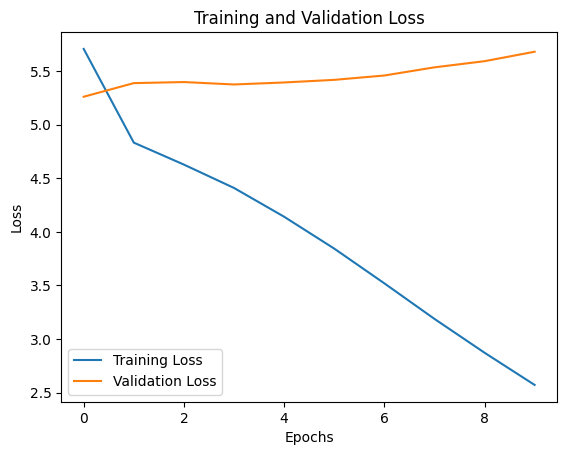

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
def predict_answer(model, question, tokenizer):
    question_seq = preprocess_sequences([question], tokenizer)
    
    decoder_input = np.array([[tokenizer.word_index['startsq']]])
    
    encoder_output, state_h, state_c = model.encoder(question_seq)
    
    predicted_tokens = []
    
    for _ in range(max_length):
        decoder_output, state_h, state_c = model.decoder(
            decoder_input,
            initial_state=[state_h, state_c]
        )
        
        predicted_token = np.argmax(decoder_output[0, -1, :])
        
        if predicted_token == tokenizer.word_index.get('endsq', 1):
            break
            
        predicted_tokens.append(predicted_token)
        decoder_input = np.array([[predicted_token]])
    
    predicted_words = []
    for token in predicted_tokens:
        for word, index in tokenizer.word_index.items():
            if index == token:
                predicted_words.append(word)
                break
    
    return ' '.join(predicted_words)

In [29]:
test_question = "Which year was used for estimates in the 2011 report"
answer = predict_answer(model, test_question, tokenizer)
print(f"Question: {test_question}")
print(f"Answer: {answer}")

Question: Which year was used for estimates in the 2011 report
Answer: 2010


In [30]:
questions[1234]

'what will always be restricted in terms of a perpetrators intent to destroy'

In [31]:
answers[1234]

'the opportunity presented to him'

eval:

In [32]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [33]:
# predict
predicted_texts = [predict_answer(model, question, tokenizer) for question in eval_questions]

# evaluate using f1
import evaluate

squad_metric = evaluate.load("squad")

results = squad_metric.compute(
    predictions=[{"id": ex["id"], "prediction_text": pred} 
                 for ex, pred in zip(eval_df.iloc[:5000].to_dict("records"), predicted_texts)],
    references=[{"id": ex["id"], "answers": ex["answers"]} for ex in eval_df.iloc[:5000].to_dict("records")]
)

print(results)

{'exact_match': 0.02, 'f1': 0.6161714569661797}


## Phase 2:

In [34]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)  
        self.W2 = tf.keras.layers.Dense(units)  
        self.V = tf.keras.layers.Dense(1)

    def call(self, decoder_hidden_state, encoder_outputs):

        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)  
        score = self.V(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_outputs)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_outputs  
        context_vector = tf.reduce_sum(context_vector, axis=1)  

        return context_vector, attention_weights

class Encoder2(layers.Layer):
    def __init__(self, embedding_matrix, hidden_units, **kwargs):
        super().__init__(**kwargs)
        vocab_size, embedding_dim = embedding_matrix.shape
        
        self.embedding = layers.Embedding(
            vocab_size, 
            embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
            mask_zero=True
        )
        self.lstm = layers.LSTM(
            hidden_units, 
            return_sequences=True, 
            return_state=True,
        )

    def call(self, inputs):
        x = self.embedding(inputs)
        output, state_h, state_c = self.lstm(x)
        return output, state_h, state_c

class Decoder2(layers.Layer):
    def __init__(self, embedding_matrix, hidden_units, **kwargs):
        super().__init__(**kwargs)
        vocab_size, embedding_dim = embedding_matrix.shape
        
        self.embedding = layers.Embedding(
            vocab_size, 
            embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
            mask_zero=True
        )

        self.attention = BahdanauAttention(hidden_units)
        
        self.lstm = layers.LSTM(
            hidden_units * 2, 
            return_sequences=True, 
            return_state=True,
        )
        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
                
        self.dense = layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, encoder_outputs, initial_state):
        x = self.embedding(inputs)

        context_vector, _ = self.attention(initial_state[0], encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)
        context_vector = tf.repeat(context_vector, repeats=tf.shape(x)[1], axis=1)
        x = tf.concat([context_vector, x], axis=-1)
        
        x, state_h, state_c = self.lstm(x, initial_state=initial_state)
        output = self.dense(x)
        return output, state_h, state_c

In [35]:
class QuestionAnswering2(Model):
    def __init__(self, embedding_matrix, hidden_units, **kwargs):
        super().__init__(**kwargs)
        self.question_encoder = Encoder2(embedding_matrix, hidden_units)
        self.context_encoder = Encoder2(embedding_matrix, hidden_units)
        self.decoder = Decoder2(embedding_matrix, hidden_units)  # doubling hidden size

    def call(self, inputs):
        question, context, answer = inputs

        question_output, q_h, q_c = self.question_encoder(question)
        context_output, c_h, c_c = self.context_encoder(context)

        encoder_outputs = tf.concat([question_output, context_output], axis=1)

        combined_h = tf.concat([q_h, c_h], axis=-1)
        combined_c = tf.concat([q_c, c_c], axis=-1)

        decoder_output, _, _ = self.decoder(answer, encoder_outputs=encoder_outputs, initial_state=[combined_h, combined_c])
        return decoder_output

In [36]:
X_questions = preprocess_sequences(questions, tokenizer)
X_context = preprocess_sequences(context, tokenizer)
X_answers = preprocess_sequences(answers_new, tokenizer)

decoder_input = X_answers[:, :-1]
decoder_target = X_answers[:, 1:]

model = QuestionAnswering2(embedding_matrix, hidden_units=256)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    [X_questions, X_context, decoder_input],
    decoder_target,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 157ms/step - accuracy: 0.9075 - loss: 1.5619 - val_accuracy: 0.9450 - val_loss: 0.5544
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accuracy: 0.9365 - loss: 0.5494 - val_accuracy: 0.9453 - val_loss: 0.5529
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 161ms/step - accuracy: 0.9382 - loss: 0.5076 - val_accuracy: 0.9454 - val_loss: 0.5506
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 162ms/step - accuracy: 0.9371 - loss: 0.4834 - val_accuracy: 0.9456 - val_loss: 0.5499
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 162ms/step - accuracy: 0.9386 - loss: 0.4305 - val_accuracy: 0.9457 - val_loss: 0.5506
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 162ms/step - accuracy: 0.9399 - loss: 0.3790 - val_accuracy: 0.9456 - val_loss: 0.5585
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 162ms/step - accuracy: 0.9418 - loss: 0.3250 - val_accuracy: 0.9455 - val_loss: 0.5660
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 162ms/step - accuracy: 0.9454 - loss: 0.2767 - val

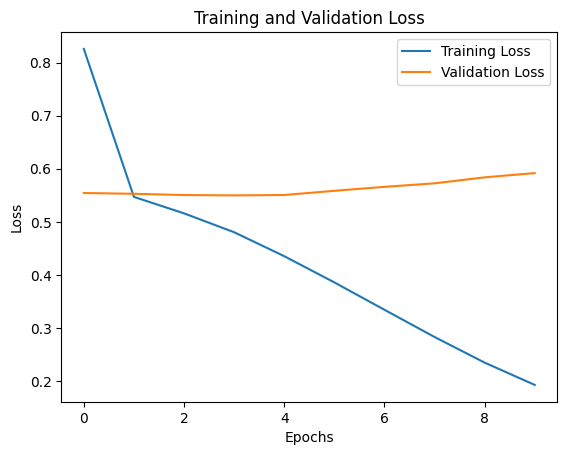

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [38]:
def predict_answer2(model, question, context, tokenizer):
    question_seq = preprocess_sequences([question], tokenizer)
    context_seq = preprocess_sequences([context], tokenizer)
    
    decoder_input = np.array([[tokenizer.word_index['startsq']]])
    
    question_output, q_h, q_c = model.question_encoder(question_seq)
    context_output, c_h, c_c = model.context_encoder(context_seq)

    encoder_outputs = tf.concat([question_output, context_output], axis=1)

    h = tf.concat([q_h, c_h], axis=-1)
    c = tf.concat([q_c, c_c], axis=-1)
    
    predicted_tokens = []
    
    for _ in range(max_length):
        x = model.decoder.embedding(decoder_input)

        context_vector, _ = model.decoder.attention(h, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        x = tf.concat([context_vector, x], axis=-1)
        
        output, h, c = model.decoder.lstm(x, initial_state=[h, c])
        
        token_probs = model.decoder.dense(output)
        
        predicted_token = tf.argmax(token_probs[0, -1]).numpy()
        
        if predicted_token == tokenizer.word_index.get('endsq', 1):
            break
            
        predicted_tokens.append(predicted_token)
        decoder_input = np.array([[predicted_token]])
    
    predicted_words = []
    for token in predicted_tokens:
        for word, index in tokenizer.word_index.items():
            if index == token:
                predicted_words.append(word)
                break
    
    return ' '.join(predicted_words)

In [39]:
test_question = questions[1236]
test_context = context[1236]
answer = predict_answer2(model, test_question, test_context, tokenizer)
print(f"Question: {test_question}")
print(f"Context: {test_context}")
print(f"Answer: {answer}")

Question: on which date did the genocide convention become effective
Context: the convention came into force as international law on 12 january 1951 after the minimum 20 countries became parties at that time however only two of the five permanent members of the un security council were parties to the treaty france and the republic of china the soviet union ratified in 1954 the united kingdom in 1970 the peoples republic of china in 1983 having replaced the taiwanbased republic of china on the unsc in 1971 and the united states in 1988 this long delay in support for the convention by the worlds most powerful nations caused the convention to languish for over four decades only in the 1990s did the international law on the crime of genocide begin to be enforced
Answer: the late 1990s


eval:

In [40]:
# predict
predicted_texts = [predict_answer2(model, question, context, tokenizer) for question, context in zip(eval_questions, eval_context)]

# evaluate using f1
import evaluate

squad_metric = evaluate.load("squad")

results = squad_metric.compute(
    predictions=[{"id": ex["id"], "prediction_text": pred} 
                 for ex, pred in zip(eval_df.iloc[:5000].reset_index(drop=True).to_dict("records"), predicted_texts)],
    references=[{"id": ex["id"], "answers": ex["answers"]} for ex in eval_df.iloc[:5000].reset_index(drop=True).to_dict("records")]
)

print(results)

{'exact_match': 0.08, 'f1': 0.4045150176620764}


In [41]:
for i in range(30,36):
    print(f"Q: {eval_questions[i]}")
    print(f"Context: {eval_context[i]}...")
    print(f"True A: {eval_answers[i]}")
    print(f"Predicted: {predicted_texts[i]}")
    print("-" * 40)

Q: what is the title of notre dames theodore hesburgh
Context: the joan b kroc institute for international peace studies at the university of notre dame is dedicated to research education and outreach on the causes of violent conflict and the conditions for sustainable peace it offers phd masters and undergraduate degrees in peace studies it was founded in 1986 through the donations of joan b kroc the widow of mcdonalds owner ray kroc the institute was inspired by the vision of the rev theodore m hesburgh csc president emeritus of the university of notre dame the institute has contributed to international policy discussions about peace building practices...
True A: president emeritus of the university of notre dame
Predicted: the college of the college of the college of the college of the college of the college of the college of the college of cardinals
----------------------------------------
Q: in what year was the joan b kroc institute for international peace studies founded
Context